### HELLO! This is a simple tool I have created to query optical photometry for nearby galaxies at a location of you choosing from SDSS DR12 in Vizier. Hope you find it useful! --Vic 07/31/2020

#### Note from CDK - this is a python 3 notebook.  If you receive an error on the "import util" step, make sure you are running this notebook in a python 3 environment

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from astropy.visualization import ImageNormalize, ZScaleInterval
from astropy.io import fits, ascii
import IPython.display
from IPython.core.display import display, HTML
import ipywidgets as widgets
import pickle
import dustmaps.sfd
import numpy as np
import os
from astropy import units as u
from astropy.io import fits
import astropy.wcs as wcs
from astropy.visualization import simple_norm

# This file contains all external dependencies
from utilities import util

dustmaps.sfd.fetch()
sfd = dustmaps.sfd.SFDQuery()

Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.
Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.


# Name of GRB, metadata, coordinates, extinction, PS1 image

Successfully downloaded Swift GRB data...
Got GRB metadata
Time: 00:27:30
Trigger Number: 1044426
BAT T90: 
XRT RA: 06:59:29.86
XRT Dec: 04:55:20.4
Milky Way Av=2.3042 mag
We need to download 1 PS1 images.
data/rings.v3.skycell.1866.059.stk.r.unconv.fits exists.  Continuing...


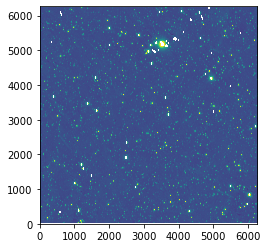

In [3]:
data_path = 'data/'
object_name = 'GRB210421A'
ra  = '05:08:00'
dec = '26:11:00'

# Parse coord
coord = util.parse_coord(ra, dec)

# Get Swift data
swift_data = util.get_grb_data(object_name)

# Get MW Av
av = sfd(coord) * 3.1
print('Milky Way Av={0} mag'.format(('%7.4f'%av).strip()))

# Get PS1 image if it exists
img = util.downloadPS1(coord, 'r', outdir=data_path)
if img and os.path.exists(img):
    hdu = fits.open(img)
    data = hdu[1].data
    norm = simple_norm(data, 'linear', percent=99.)
    plt.imshow(data, norm=norm, origin='lower', cmap='viridis')

### GCN search - this will download GCN data and display hyperlinks to GCNs that contain photometry

In [7]:
# Works on GRB name.  Make sure you have a GRB name similar to those in GCN titles
# Display all GCN urls with photometry.  Set all_url=True to get all GCNs instead
gcns = util.get_grb_gcn(object_name)
all_url = False
if gcns is not None:
    gcn_mask = util.get_mag_mask(gcns)
    if all_url: gcn_mask=np.array([True]*len(gcns))
    for gcn in np.array(gcns)[gcn_mask]:
        subj=util.parse_circular_subject(gcn)
        num=util.parse_circular_number(gcn)
        if num and subj:
            url=util.get_gcn_url(num)
            disp="""<a href="{0}" target="_blank">{1}</a>""".format(url, subj)
            display(HTML(disp))

### Catalog search - this will grab metadata for sources around input coord

In [3]:
# This method will search and crossmatch catalogs given an input list
# of catalogs.  The output is an astropy table keyed by as catname_key
# where key is the original key in each catalog
catnames=            ['ps1dr2','strm','sdssdr12','2mass','unwise','glade','des']
catalog = util.search_catalogs(coord, catnames, search_radius=2.564*u.arcmin,
    match_radius=2.0*u.arcsec, outfile=os.path.join(data_path,object_name+'.cat'))


# Mask the catalog around input coord
print(util.mask_catalog_around_coord(catalog, coord, radius=10.0*u.arcsec))

data/GRB210323A.cat exists.  Do you want to use this catalog?([y]/n): y
    ps1dr2_objName    ps1dr2_objAltName1 ... unwise_FW2 unwise_e_FW2
--------------------- ------------------ ... ---------- ------------
PSO J317.9440+25.3697               -999 ...     -999.0       -999.0
PSO J317.9470+25.3678               -999 ...     -999.0       -999.0
PSO J317.9477+25.3679               -999 ...     -999.0       -999.0
                   --                 -- ...     -999.0       -999.0
                   --                 -- ...        0.0          0.0


### If you want an image of where you are looking at, you can use this!

We need to download 2 PS1 images.
data/rings.v3.skycell.1920.030.stk.r.unconv.fits exists.  Continuing...


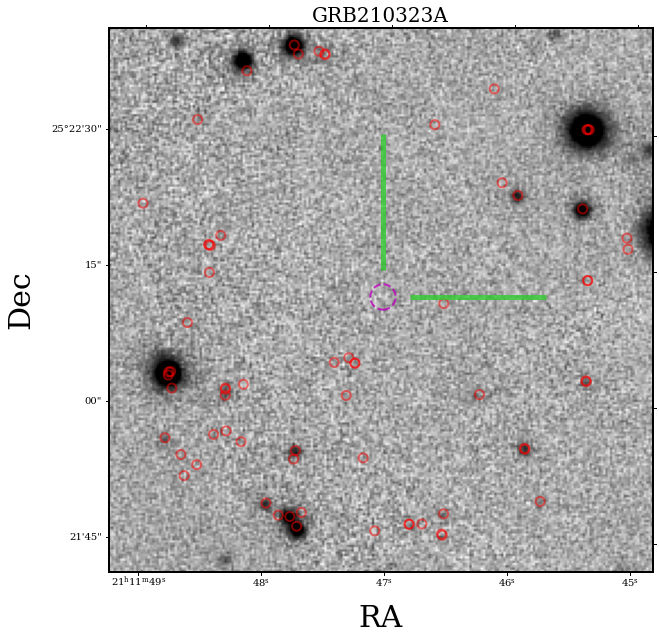

In [46]:
# Here is an image of the cut out. I bet it looks super pretty!
# First tries SDSS, then PS1, then DES, then SkyMapper to get jpeg
# should have 100% sky coverage from those surveys
imfile = util.downloadPS1(coord, 'r')
boxsize = 1.0 # in arcmin
figsize=10

# Clip to boxsize
from astropy.nddata import Cutout2D
from astropy import units as u
from astropy.coordinates import SkyCoord
import astropy.wcs as wcs

hdu = fits.open(imfile)
data = hdu[1].data
wcs_img = wcs.WCS(hdu[1].header)
size = u.Quantity((boxsize, boxsize), u.arcmin)
position = (coord.ra.degree, coord.dec.degree)
cutout = Cutout2D(data, coord, size, wcs=wcs_img)

#%matplotlib widget
%matplotlib inline
fig, ax = plt.subplots(figsize=(figsize,figsize))
image = cutout.data
wcs_object = cutout.wcs

ax = plt.subplot(projection=wcs_object)
ax.imshow(image, cmap='gray_r', norm=ImageNormalize(image, interval=ZScaleInterval()))

xsize=cutout.data.shape[0]
ysize=cutout.data.shape[1]

ax.set_title(object_name,fontsize=20)
x_center, y_center = wcs_object.all_world2pix(coord.ra.deg,coord.dec.deg,1)
ax.hlines(y_center,x_center+int(0.05*xsize),x_center+int(0.3*xsize),color='limegreen',
          alpha=0.8,linewidth=0.5*figsize)
ax.vlines(x_center,y_center+int(0.05*ysize),y_center+int(0.3*ysize),color='limegreen',
          alpha=0.8,linewidth=0.5*figsize)

# These are somewhat redundant with the RA/Dec box, so probably not necessary
#ax.hlines(50,170,470,color='k',linewidth=3)
#ax.vlines(470,50,350,color='k',linewidth=3)
#ax.text(400,400,'N',color='k',fontsize=15)
#ax.text(35,50,'E',color='k',fontsize=15)
#ax.hlines(int(0.05*ysize), int(0.7*xsize), int(0.95*xsize), color='red', linewidth=3)
#ax.vlines(int(0.05*xsize), int(0.2*ysize), int(0.5*ysize), color='red', linewidth=3)
#ax.text(int(0.4*xsize), int(0.4*ysize), 'N', color='red', fontsize=1.5*figsize)
#ax.text(int(0.05*xsize), int(0.05*ysize), 'E', color='red', fontsize=1.5*figsize)

try:
    #xrt_pos = util.parse_coord(swift_data['BAT RA'], swift_data['BAT Dec'][1:])
    xrt_pos = coord
    x_xrt, y_xrt = wcs_object.all_world2pix(xrt_pos.ra.deg,xrt_pos.dec.deg,1)
    ax.add_patch(patches.Circle((x_xrt,y_xrt),radius=np.float(swift_data['BAT Error Radius'])/0.25,
                                edgecolor='m',alpha=0.8,facecolor='none',
                                linewidth=2,linestyle='--',
                                label='XRT position at RA = %.3f, Dec = %.3f'%(xrt_pos.ra.deg, xrt_pos.dec.deg),
                                picker=True))
except:
    print('No XRT position.')

for i in range(len(catalog)):
   #x, y = wcs_object.all_world2pix(xrt_pos.ra.deg,xrt_pos.dec.deg,1)
    catcoord = SkyCoord(catalog['ra'][i], catalog['dec'][i], unit='deg')
    if catcoord.separation(coord) > 0.5*boxsize * u.arcmin: continue
    x, y = wcs_object.all_world2pix(catcoord.ra.degree, catcoord.dec.degree, 1)
    ax.add_patch(patches.Circle((x,y),radius=2,edgecolor='r',alpha=0.5,facecolor='none',
                                linewidth=2,linestyle='-',
                                label='Galaxy at RA = %.3f, Dec = %.3f'%(catalog['ra'][i],catalog['dec'][i]),
                                picker=True))    

ax.set_xlabel('RA', fontsize=3.0*figsize)
ax.set_ylabel('Dec', fontsize=3.0*figsize)
fig.canvas.mpl_connect('click_pos', lambda event: onclick())
fig.canvas.mpl_connect('pick_event', lambda event: onpick())

plt.show()

### Once you have the results, there are several things you can do. One of them is finding the probability chance coincident (Pcc) of the nearby galaxies which essentially tells you how likely that the GRB originated from a galaxy. The lower the Pcc, the more probable. 

In [48]:
# The function you can use to calcilate that is here:
def pcc(r,m): 
    sigma = (1/(0.33*np.log(10)))*10**(0.33*(m-24)-2.44) 
    prob = 1-np.exp(-(np.pi*(r**2)*sigma)) 
    return prob

#lst = util.readData(data_path+object_name+'.cat')
#nest = util.sorting(lst)
#final = util.data(nest)
#util.ordering(final,data_path+object_name+'.txt')

# An example of what a plot of Pcc as a function of distance looks like is here. This is what I did for GRB200522A. 
#with open(data_path+object_name+'.txt', 'rb') as fp:
#    result = pickle.load(fp)

# Make a list of r_mag that corresponds to each galaxy near the GRB
r_mag = catalog['ps1dr2_rMeanKronMag']
#print(r_mag)

# Distance is in arcsecond, not arcminute of the galaxy from the GRB
coords = SkyCoord(catalog['ra'], catalog['dec'], unit='deg')
distance = [c.separation(coord).arcsec for c in coords]
#print(distance)

# Make a list of photometric redshift
#phot = [line[10] for line in result]
#print(phot)
    
prob = []
for i in range(len(r_mag)):
    prob.append(pcc(distance[i],r_mag[i]))
        
#print(prob)

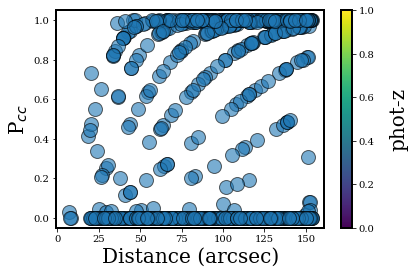

In [49]:
plt.figure()
plt.rcParams['figure.figsize'] = [10, 8]
# = plt.subplot(21.137, 0.316, c=0.5537)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.linewidth'] = 2
plt.scatter(distance, prob, marker = "o", cmap='plasma', alpha = 0.6, s=195, edgecolors='black')
plt.ylabel('P$_{cc}$', fontsize = 20)
plt.xlabel('Distance (arcsec)', fontsize = 20)
clb = plt.colorbar()
clb.solids.set_alpha(1)
clb.set_label('phot-z', fontsize = 20, labelpad=15, rotation=90)
plt.savefig(object_name+'_pcc.png', format = 'pdf', dpi=300, bbox_inches="tight")
plt.show()

#### You can also sort out other lists of information such as the redshift and distance to make a scatter plot of redshifts as a function of distance. That can be helpful for figuring out whether the host is in a galaxy cluster or not. 